In [1]:
import numpy
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Hypertension patients table layout

In [2]:
hypertension_patients = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/hypertension_patients")
hypertension_patients.head()

,subject_id,hadm_id,hypertension,train
0,73037,192662,1,1
1,25763,195141,1,1
2,40310,157609,0,1
3,65416,171418,1,1
4,26263,105662,1,1


# Hypertension charts table layout

In [3]:
hypertension_charts = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/hypertension_charts")
hypertension_charts.head()

,subject_id,hadm_id,charttime,itemid,valuenum
0,36,165660,2134-05-12 13:00:00,220045,86.0
1,36,165660,2134-05-12 13:00:00,220181,84.0
2,36,165660,2134-05-12 13:00:00,220210,21.0
3,36,165660,2134-05-12 14:00:00,220045,85.0
4,36,165660,2134-05-12 14:00:00,220181,65.0


In [4]:
#220045
def filter(itemid):
    filtered_data = hypertension_charts.loc[hypertension_charts['itemid'] == itemid]
    #removing patients with fewer than 2 measurements
    temp = pd.core.frame.DataFrame(filtered_data.groupby(['subject_id','hadm_id'],as_index = False).valuenum.agg(['count'])).reset_index() 
    temp = temp.loc[temp['count']<2]
    filtered_data = filtered_data.loc[~(filtered_data['subject_id'].isin(temp['subject_id']) & filtered_data['hadm_id'].isin(temp['hadm_id']))]
    
    #preparing the data for LSTM
    filtered_data_lstm = filtered_data
    filtered_data_lstm = pd.core.frame.DataFrame(filtered_data_lstm.groupby(['subject_id','hadm_id']).valuenum.apply(list)).reset_index()
    filtered_data_lstm = pd.merge(hypertension_patients, filtered_data_lstm, on=['subject_id','hadm_id'], how='inner')
    filtered_data_lstm = filtered_data_lstm.drop(['subject_id','hadm_id'],axis=1)

    #finding mean,max and min
    filtered_data = pd.core.frame.DataFrame(filtered_data.groupby(['subject_id','hadm_id']).valuenum.agg(['mean','max','min'])).reset_index()
    filtered_data = pd.merge(hypertension_patients, filtered_data, on=['subject_id','hadm_id'], how='inner')
    filtered_data = filtered_data.drop(['subject_id','hadm_id'],axis=1)
    filtered_data_lr = filtered_data
    return filtered_data_lr,filtered_data_lstm

In [5]:
def logistic_regression(data):
    #spliting the training and testing data
    X = data.drop(['hypertension'],axis=1)
    X_train,X_test = X.loc[X['train']==1],X.loc[X['train']==0]
    X_train,X_test = X_train.drop(['train'],axis=1),X_test.drop(['train'],axis=1)
    Y = data[['hypertension','train']] 
    Y_train,Y_test = Y.loc[Y['train']==1],Y.loc[Y['train']==0]
    Y_train,Y_test = Y_train.drop(['train'],axis=1).values.squeeze(),Y_test.drop(['train'],axis=1).values.squeeze()
    
    #training the model
    classifier = LogisticRegression(random_state=0,penalty="l2", C=1)
    classifier.fit(X_train, Y_train)
    Y_pred = classifier.predict(X_test)
    Y_test_prob = classifier.predict_proba(X_test)
    print("AUC: ",roc_auc_score(Y_test,Y_test_prob[:,1])*100)

In [6]:
heart_rate_data_lr, heart_rate_data_lstm= filter(220045)
heart_rate_data_lr.head()

,hypertension,train,mean,max,min
0,1,1,91.714286,107.0,67.0
1,0,1,111.732143,152.0,80.0
2,1,1,96.074074,108.0,78.0
3,0,0,71.750000,84.0,60.0
4,0,1,72.875000,111.0,32.0


In [45]:
logistic_regression(heart_rate_data_lr)

AUC:  51.2145890712


In [36]:
respiratory_rate_data_lr, respiratory_rate_data_lstm= filter(220210)
respiratory_rate_data_lr.head()

,hypertension,train,mean,max,min
0,1,1,23.604167,33.0,17.0
1,0,1,20.392857,43.0,5.0
2,1,1,19.692308,27.0,12.0
3,0,0,21.333333,26.0,16.0
4,0,1,23.500000,32.0,15.0


In [37]:
logistic_regression(respiratory_rate_data_lr)

AUC:  53.1044190586


In [38]:
o2_saturation_data_lr,o2_saturation_data_lstm = filter(220277)
o2_saturation_data_lr.head()

,hypertension,train,mean,max,min
0,1,1,94.520833,98.0,88.0
1,0,1,96.608434,100.0,10.0
2,1,1,96.896552,100.0,90.0
3,0,0,93.666667,96.0,91.0
4,0,1,97.740741,100.0,96.0


In [39]:
logistic_regression(o2_saturation_data_lr)

AUC:  50.8704287255


In [40]:
blood_pressure_data_lr, blood_pressure_data_lstm = filter(220181)
blood_pressure_data_lr.head()

,hypertension,train,mean,max,min
0,1,1,80.418605,108.0,63.0
1,0,1,101.345912,146.0,66.0
2,1,1,64.666667,71.0,59.0
3,0,0,80.666667,92.0,72.0
4,0,1,97.105263,197.0,71.0


In [41]:
logistic_regression(blood_pressure_data_lr)

AUC:  52.8380577604


In [8]:
heart_rate_data_lstm.head()

,hypertension,train,valuenum
0,1,1,"[82.0, 89.0, 93.0, 103.0, 104.0, 101.0, 105.0,..."
1,0,1,"[128.0, 129.0, 129.0, 135.0, 134.0, 134.0, 134..."
2,1,1,"[97.0, 99.0, 94.0, 92.0, 93.0, 92.0, 96.0, 94...."
3,0,0,"[82.0, 84.0, 61.0, 60.0]"
4,0,1,"[40.0, 38.0, 36.0, 44.0, 43.0, 47.0, 47.0, 66...."


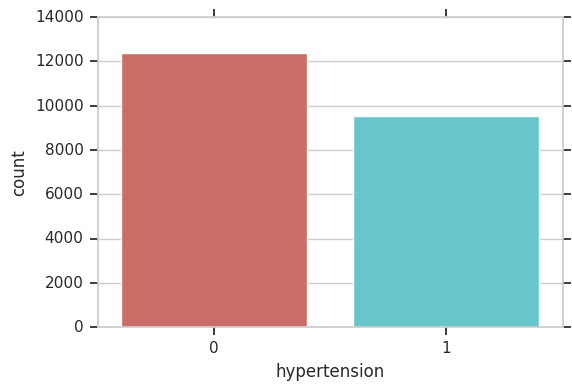

In [10]:
len(heart_rate_data_lstm['valuenum'][0])
sns.countplot(x='hypertension',data=heart_rate_data_lstm, palette='hls')
plt.show()

In [11]:
heart_rate_data_lstm['length'] = heart_rate_data_lstm.valuenum.apply(lambda x: len(x))

In [9]:
#heart_rate_data_lstm.head()
heart_rate_data_lstm.groupby(['hypertension'])['length'].mean()

hypertension
0    132.688844
1    117.477308
Name: length, dtype: float64

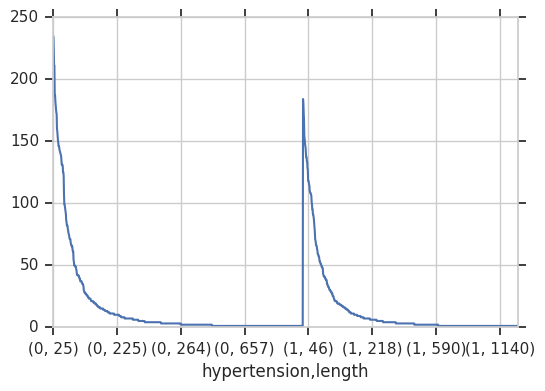

In [43]:
heart_rate_data_lstm.groupby(['hypertension'])['length'].value_counts().plot()
plt.show()

In [48]:
heart_rate_data_lstm = heart_rate_data_lstm.drop('length',axis=1)
heart_rate_data_lstm.head()

,hypertension,train,valuenum
0,1,1,"[82.0, 89.0, 93.0, 103.0, 104.0, 101.0, 105.0,..."
1,0,1,"[128.0, 129.0, 129.0, 135.0, 134.0, 134.0, 134..."
2,1,1,"[97.0, 99.0, 94.0, 92.0, 93.0, 92.0, 96.0, 94...."
3,0,0,"[82.0, 84.0, 61.0, 60.0]"
4,0,1,"[40.0, 38.0, 36.0, 44.0, 43.0, 47.0, 47.0, 66...."


In [122]:
X = heart_rate_data_lstm.drop(['hypertension'],axis=1)
X_train,X_test = X.loc[X['train']==1],X.loc[X['train']==0]
X_train,X_test = X_train.drop(['train'],axis=1),X_test.drop(['train'],axis=1)
Y = heart_rate_data_lstm[['hypertension','train']] 
Y_train,Y_test = Y.loc[Y['train']==1],Y.loc[Y['train']==0]
Y_train,Y_test = Y_train.drop(['train'],axis=1).values.squeeze(),Y_test.drop(['train'],axis=1).values.squeeze()

In [131]:
X_train = X_train.valuenum.apply(lambda x: [[i] for i in x])

In [136]:
#Y_train = [[i] for i in Y_train]
Y_train = numpy.array(Y_train)
X_train = numpy.array(X_train)

In [149]:
x = numpy.array([X_train[0]])
x.shape

(1, 49, 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(12, input_shape=(None, 1)))
model.add(Dropout(0.5))
model.add(Dense(1,init='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')

#X_train = X_train['valuenum'].tolist()
#model.fit(X_train, Y_train, batch_size=16, epochs=10)
#score = model.evaluate(X_test, Y_test, batch_size=16)
#print(score)

#
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))

def train_generator():
    w=0
    while True:
        x_train = numpy.array([X_train[w]])
        y_train = numpy.array([Y_train[w]])
        w+=1
        if w==15297:
            w=0
        yield x_train, y_train

model.fit_generator(train_generator(), steps_per_epoch=15297, epochs=3, verbose=1)

/home/pulkitmathur1800/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="normal", activation="sigmoid")`


Epoch 1/3
15297/15297 [==============================] - 1046s 68ms/step - loss: 0.6862
Epoch 2/3
15297/15297 [==============================] - 849s 55ms/step - loss: 0.6858
Epoch 3/3
15297/15297 [==============================] - 847s 55ms/step - loss: 0.6859


In [ ]:
score = model.evaluate(X_test, Y_test)